# MTL in Detection of Emotion, Toxicity Classification

### 1. Importing Libraries

In [1]:
from transformers import TFBertModel, BertTokenizer
from keras.layers import Input, Bidirectional, LSTM, Dense, Concatenate
from keras.models import Model
from keras.preprocessing import text, sequence
from keras.utils import pad_sequences

e:\Mini Projects\Thesis\report-system-back\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 2. Declaring Constants

In [2]:
# Constants
MAX_SEQ_LEN = 50
LSTM_UNITS = 64
# VOCAB_SIZE = 10000
# EMBEDDING_DIM = 128

# Task-specific constants
NUM_EMOTION_CLASSES = 7
# NUM_SENTIMENT_CLASSES = 3
NUM_TOXICITY_CLASSES = 7

### 3. Initializing Bert Model and Tokenizer, then Creating a input layers

In [3]:
# Initialize the BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [4]:
# Input and BERT layers
input_layer = Input(shape=(MAX_SEQ_LEN,), dtype='int32', name='input')
# embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQ_LEN)(input_layer)
bert_output = bert_model(input_layer)

### 4. Creating a BiLSTM layer

In [5]:
# Bidirectional LSTM layer
bi_lstm_layer = Bidirectional(LSTM(LSTM_UNITS))(bert_output[0])

### 5. Creating Dense layers for each task 

In [6]:
# Task-specific layers
emotion_output = Dense(NUM_EMOTION_CLASSES, activation='sigmoid', name='emotion_output')(bi_lstm_layer)
# sentiment_output = Dense(NUM_SENTIMENT_CLASSES, activation='softmax', name='sentiment_output')(bi_lstm_layer)
toxicity_input = Concatenate(name="concatination_of_blstm_emotion")([bi_lstm_layer, emotion_output])
toxicity_output = Dense(NUM_TOXICITY_CLASSES, activation='sigmoid', name='toxicity_output')(toxicity_input)

###  6. Creating a Model

In [7]:
# Define the model
model = Model(name="MTL_BERT_ET",inputs=input_layer, outputs=[emotion_output, toxicity_output])

# Compile the model
model.compile(
    optimizer='adam',
    loss={
            'emotion_output': 'categorical_crossentropy',
            #   'sentiment_output': 'categorical_crossentropy',
            'toxicity_output': 'categorical_crossentropy'
        },
    metrics=['accuracy', 'Precision', 'Recall'])

# Summary of the model
model.summary()

Model: "MTL_BERT_ET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 100)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input[0][0]']                  
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 100,                                               
                                 768),                                                            
                                 pooler_output=(Non                                     

## Export Model Flow[]

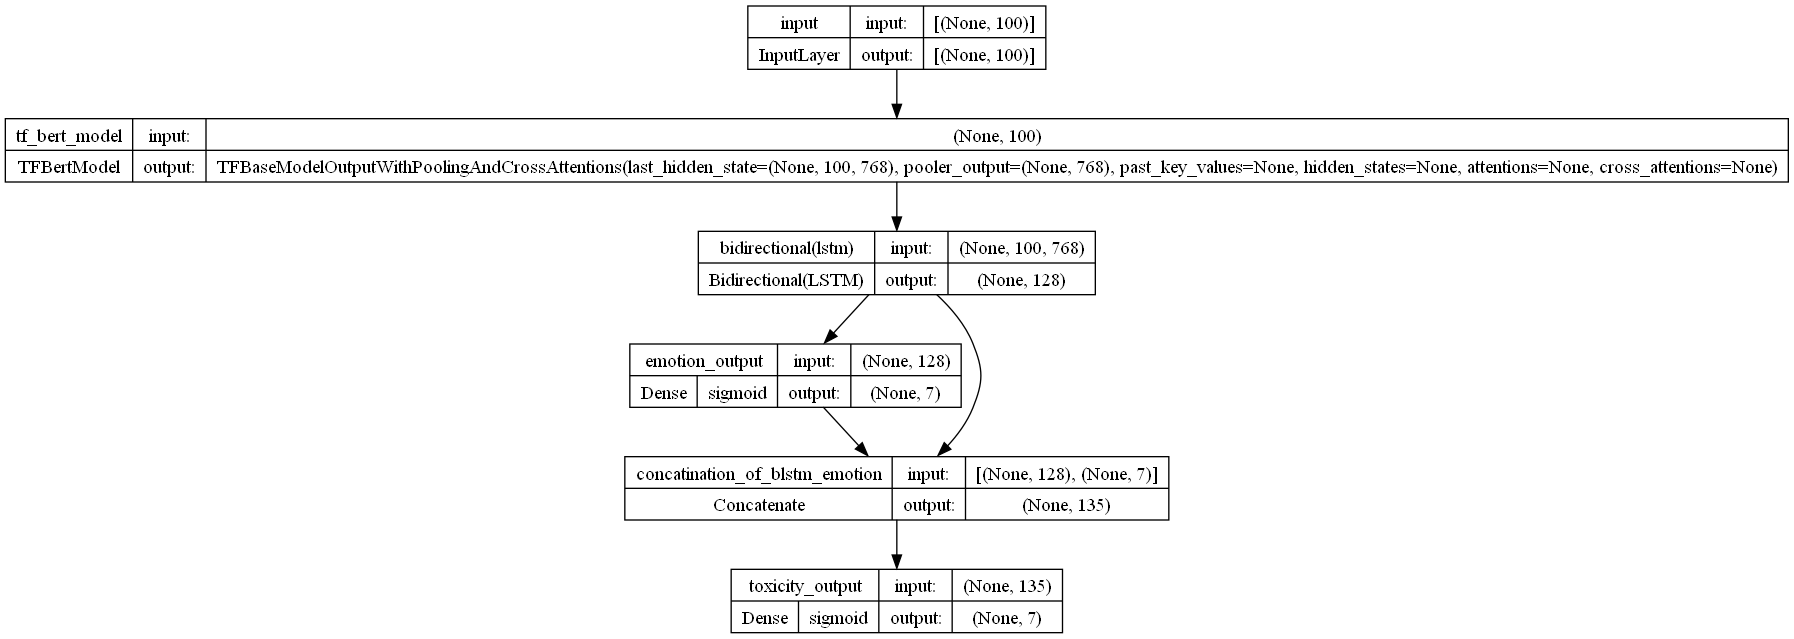

In [8]:
# Path: src\api\notebook\model.mtl.ipynb
from keras.utils import plot_model
plot_model(model, show_layer_activations=True,show_layer_names=True,to_file='model.png', show_shapes=True)

## Running in Sample Dataset

In [9]:
import numpy as np
import pandas as pd

In [10]:


# Sample chat data
chats = [
    "I really enjoyed the movie last night!",
    "I'm not sure if I like this restaurant.",
    "This is a great book.",
    "I can't believe how rude that person was.",
    "This product is amazing!",
    "I strongly disagree with your statement.",
    "I feel neutral about this topic.",
    "You should be ashamed of yourself!",
    "I think your idea is brilliant.",
    "You are the worst!",
]

# Labels for emotion and toxicity
emotion_labels = ['positive', 'neutral', 'positive', 'negative', 'positive',
                  'negative', 'neutral', 'negative', 'positive', 'negative']

toxicity_labels = ['non-toxic', 'non-toxic', 'non-toxic', 'hate speech', 'non-toxic',
                   'non-toxic', 'non-toxic', 'sexism', 'non-toxic', 'sexism']

# Convert labels to one-hot encoding
num_emotion_classes = len(set(emotion_labels))
num_toxicity_classes = len(set(toxicity_labels))

emotion_label_map = {label: i for i, label in enumerate(set(emotion_labels))}
toxicity_label_map = {label: i for i, label in enumerate(set(toxicity_labels))}

emotion_labels_one_hot = np.eye(num_emotion_classes)[[emotion_label_map[label] for label in emotion_labels]]
toxicity_labels_one_hot = np.eye(num_toxicity_classes)[[toxicity_label_map[label] for label in toxicity_labels]]
arr = [(chats[i], emotion_labels[i], toxicity_labels[i]) for i in range(len(chats))]
df = pd.DataFrame(arr, columns=["Chats", "e_labels","t_labels"])
df



,Chats,e_labels,t_labels
0,I really enjoyed the movie last night!,positive,non-toxic
1,I'm not sure if I like this restaurant.,neutral,non-toxic
2,This is a great book.,positive,non-toxic
3,I can't believe how rude that person was.,negative,hate speech
4,This product is amazing!,positive,non-toxic
5,I strongly disagree with your statement.,negative,non-toxic
6,I feel neutral about this topic.,neutral,non-toxic
7,You should be ashamed of yourself!,negative,sexism
8,I think your idea is brilliant.,positive,non-toxic
9,You are the worst!,negative,sexism


## Preprocessing

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import WordNetLemmatizer

import advertools as adv

In [12]:
def removing_stopwords(dataset, message:str):
    corpus = []
    for i in range(0,len(dataset)):
        # Remove special characters
        chat = re.sub('[^a-zA-Z#]', ' ', dataset[message][i])
        chat = chat.lower()
        chat = chat.split()
        # Remove stop words
        all_stopwords_eng = stopwords.words('english')
        all_stopwords_eng.remove('not')
        all_stopwords_tag = adv.stopwords['tagalog']
        chat = [word for word in chat if not word in set(all_stopwords_eng) and word not in set(all_stopwords_tag)]
        chat = ' '.join(chat)
        corpus.append(chat)
    return corpus

In [13]:
def lemmatization(tokenized_chat):
    lem = nltk.WordNetLemmatizer()
    return tokenized_chat.apply(lambda x: [lem.lemmatize(word) for word in x])

In [24]:
# Tokenize chats using the BERT tokenizer
# Tokenize chats using the BERT tokenizer
df["clean_chats"] = removing_stopwords(df, "Chats")
d_chats = lemmatization(df["clean_chats"].apply(lambda x: x.split(' ')))
chats = d_chats.apply(lambda x: ' '.join(x)).tolist()

tokenized_chats = [bert_tokenizer.encode(chat, add_special_tokens=True, max_length=MAX_SEQ_LEN, truncation=True) for chat in chats]
# # Pad tokenized chats to the same length
# padded_chats = (tokenized_chats, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
padded_chats = pad_sequences(tokenized_chats, maxlen=MAX_SEQ_LEN, padding='pre', truncating='pre')

# Split the dataset into training and evaluation sets
train_size = int(0.8 * len(chats))

train_chats = padded_chats[:train_size]
train_emotion_labels = emotion_labels_one_hot[:train_size].astype('float32')
train_toxicity_labels = toxicity_labels_one_hot[:train_size].astype('float32')

eval_chats = padded_chats[train_size:]
eval_emotion_labels = emotion_labels_one_hot[train_size:].astype('float32')
eval_toxicity_labels = toxicity_labels_one_hot[train_size:].astype('float32')


print("Number of training samples:", len(train_chats))
print("Number of evaluation samples:", len(eval_chats))

print("Training chats shape:", train_chats.shape)
print("Training emotion labels shape:", train_emotion_labels.shape)

print("Evaluation chats shape:", eval_chats.shape)
print("Evaluation emotion labels shape:", eval_emotion_labels.shape)

Number of training samples: 8
Number of evaluation samples: 2
Training chats shape: (8, 100)
Training emotion labels shape: (8, 3)
Evaluation chats shape: (2, 100)
Evaluation emotion labels shape: (2, 3)


### Training the model

In [25]:
fitted = model.fit(
    train_chats,
    {
        'emotion_output': train_emotion_labels,
        'toxicity_output': train_toxicity_labels
    },
    epochs=7,
    batch_size=2,
    validation_data=(eval_chats, {'emotion_output': eval_emotion_labels, 'toxicity_output': eval_toxicity_labels}),
)

Epoch 1/7


TypeError: 'NoneType' object is not callable